# Eigenfaces – πλήρης υλοποίηση άσκησης

Κάνε απλώς **Run** στο IDE σου και το script:

1. Βρίσκει τον φάκελο `faces_dataset` που κάθεται δίπλα στο ίδιο το αρχείο.
2. Αν δεν υπάρχει `split.json` δημιουργεί αυτόματα train / test (1‑8, 9‑10).
3. Εκπαιδεύει PCA‑Eigenfaces με `k = 32` (αλλαγή στο CONST αν θέλεις).
4. Εμφανίζει **classification_report**, accuracy, macro‑specificity, macro‑F1.
5. Προαιρετικά φτιάχνει γράφημα Accuracy & Macro‑F1 vs k → `performance_vs_k.png`.

Για να απενεργοποιήσεις/ενεργοποιήσεις το διάγραμμα, άλλαξε τη μεταβλητή
`MAKE_CURVE` στο επάνω μέρος.

## Εισαγωγή Βιβλιοθηκών

In [17]:
from pathlib import Path
import json, re, sys

import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## Ρυθμίσεις

In [18]:
# ---------------------------------------------------------------------------
#  Ρυθμίσεις – άλλαξε μόνο αν χρειάζεται
# ---------------------------------------------------------------------------

# In Jupyter notebooks, __file__ is not defined, so we need to use a different approach
import os
ROOT_DIR   = Path(os.getcwd())                      # τρέχων φάκελος notebook
DATA_DIR   = ROOT_DIR / "faces_dataset"            # s1 … s40
SPLIT_JSON = ROOT_DIR / "split.json"
K_EIGENFACES = 32                                   # default k
MAKE_CURVE   = False                                # True για γράφημα performance vs k

# NEW: Educational visualization settings
SHOW_VISUALIZATIONS = True                          # True για εκπαιδευτικές οπτικοποιήσεις
SAVE_PLOTS = False                                   # True για αποθήκευση plots

## Βοηθητικές Συναρτήσεις

In [19]:
# ---------------------------------------------------------------------------
#  Βοηθητικά
# ---------------------------------------------------------------------------

def generate_split():
    """Δημιουργεί split.json (1‑8 → train, 9‑10 → test)."""
    persons = sorted(DATA_DIR.glob("s*"), key=lambda p: int(re.findall(r"\d+", p.name)[0]))
    splits = {"train": [], "test": []}
    for p in persons:
        splits["train"].extend([str(p / f"{i}.pgm") for i in range(1, 9)])
        splits["test"].extend([str(p / f"{i}.pgm") for i in range(9, 11)])
    SPLIT_JSON.write_text(json.dumps(splits, indent=2))
    print(f"[INFO] Δημιουργήθηκε split.json – {len(splits['train'])} train / {len(splits['test'])} test εικόνες.")


def read_image(path: Path) -> np.ndarray:
    """Διαβάζει .pgm → float32 μονόστηλο διάνυσμα."""
    try:
        img = imageio.imread(path)
    except FileNotFoundError:
        print(f"[ERROR] Δεν βρέθηκε εικόνα: {path}")
        sys.exit(1)
    return img.astype(np.float32).ravel()


def load_images(paths) -> np.ndarray:
    """Φορτώνει paths (σχετικά ή απόλυτα) → πίνακα (D, N)."""
    if not paths:
        print("[ERROR] Άδεια λίστα paths – έλεγξε split.json / faces_dataset.")
        sys.exit(1)

    vecs = []
    for p in paths:
        p = Path(p)
        if not p.is_absolute():          # κάνε resolve σε σχέση με το script
            p = ROOT_DIR / p
        vecs.append(read_image(p))
    return np.column_stack(vecs)

## Συναρτήσεις Οπτικοποίησης

In [20]:
# ---------------------------------------------------------------------------
#  Visualization Functions
# ---------------------------------------------------------------------------

def get_image_shape():
    """Βρίσκει το shape της εικόνας από την πρώτη εικόνα."""
    # Assume images are square, find dimensions from first image
    first_person = sorted(DATA_DIR.glob("s*"))[0]
    first_image = first_person / "1.pgm"
    img = imageio.imread(first_image)
    return img.shape

def visualize_sample_faces(X_train, splits, save_plots=True):
    """Εμφανίζει δείγματα προσώπων από κάθε άτομο."""
    print("\n[INFO] Δημιουργία οπτικοποίησης δειγμάτων προσώπων...")
    
    img_shape = get_image_shape()
    
    # For debugging
    print(f"[DEBUG] Image shape: {img_shape}")
    print(f"[DEBUG] X_train shape: {X_train.shape}")
    
    fig, axes = plt.subplots(4, 10, figsize=(15, 6))
    fig.suptitle('Δείγματα Προσώπων από την Βάση Δεδομένων', fontsize=16)
    
    # Create a dict to map person IDs to sets of image indices
    person_to_indices = {}
    for idx, path in enumerate(splits["train"]):
        # Handle both formats of paths: with "/" or "\\"
        path_parts = path.replace("\\", "/").split("/")
        person_id = [part for part in path_parts if part.startswith('s')][0]
        if person_id not in person_to_indices:
            person_to_indices[person_id] = []
        person_to_indices[person_id].append(idx)
    
    # Show first 4 people, 8 images each
    for i in range(4):
        person_id = f"s{i+1}"
        if person_id in person_to_indices:
            indices = person_to_indices[person_id][:8]  # Get first 8 images for this person
            
            for j in range(8):
                if j < len(indices):
                    # Get image data from X_train
                    img_data = X_train[:, indices[j]].reshape(img_shape)
                    
                    # Display the image
                    axes[i, j].imshow(img_data, cmap='gray')
                    axes[i, j].set_title(f'Person {i+1}', fontsize=8)
                axes[i, j].axis('off')
                
            # Fill remaining slots with empty plots
            for j in range(8, 10):
                axes[i, j].axis('off')
    
    plt.tight_layout()
    if save_plots:
        plt.savefig(ROOT_DIR / "01_sample_faces.png", dpi=150, bbox_inches='tight')
        print("[INFO] Αποθηκεύτηκε 01_sample_faces.png")
    plt.show()

In [21]:
def visualize_mean_face_and_centering(X_train, mean, save_plots=True):
    """Εμφανίζει το μέσο πρόσωπο και τη διαδικασία κεντραρίσματος."""
    print("\n[INFO] Δημιουργία οπτικοποίησης μέσου προσώπου...")
    
    img_shape = get_image_shape()
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle('Διαδικασία Κεντραρίσματος των Εικόνων', fontsize=16)
    
    # Original face
    axes[0, 0].imshow(X_train[:, 0].reshape(img_shape), cmap='gray')
    axes[0, 0].set_title('Αρχική Εικόνα')
    axes[0, 0].axis('off')
    
    # Mean face
    axes[0, 1].imshow(mean.reshape(img_shape), cmap='gray')
    axes[0, 1].set_title('Μέσο Πρόσωπο')
    axes[0, 1].axis('off')
    
    # Centered face
    centered = X_train[:, 0] - mean.ravel()
    axes[0, 2].imshow(centered.reshape(img_shape), cmap='gray')
    axes[0, 2].set_title('Κεντραρισμένη Εικόνα')
    axes[0, 2].axis('off')
    
    # Show a few more examples
    for i, idx in enumerate([10, 50, 100]):
        if idx < X_train.shape[1]:
            centered = X_train[:, idx] - mean.ravel()
            axes[1, i].imshow(centered.reshape(img_shape), cmap='gray')
            axes[1, i].set_title(f'Κεντραρισμένη #{idx+1}')
            axes[1, i].axis('off')
    
    plt.tight_layout()
    if save_plots:
        plt.savefig(ROOT_DIR / "02_mean_face_centering.png", dpi=150, bbox_inches='tight')
        print("[INFO] Αποθηκεύτηκε 02_mean_face_centering.png")
    plt.show()

In [22]:
def visualize_eigenfaces(eigenfaces, k_show=16, save_plots=True):
    """Εμφανίζει τα πρώτα k eigenfaces."""
    print(f"\n[INFO] Δημιουργία οπτικοποίησης {k_show} eigenfaces...")
    
    img_shape = get_image_shape()
    rows = 4
    cols = k_show // rows
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    fig.suptitle(f'Τα πρώτα {k_show} Eigenfaces (Κύρια Συστατικά)', fontsize=16)
    
    for i in range(k_show):
        row, col = i // cols, i % cols
        eigenface = eigenfaces[:, i].reshape(img_shape)
        
        # Normalize for better visualization
        eigenface_norm = (eigenface - eigenface.min()) / (eigenface.max() - eigenface.min())
        
        axes[row, col].imshow(eigenface_norm, cmap='gray')
        axes[row, col].set_title(f'Eigenface {i+1}', fontsize=10)
        axes[row, col].axis('off')
    
    plt.tight_layout()
    if save_plots:
        plt.savefig(ROOT_DIR / "03_eigenfaces.png", dpi=150, bbox_inches='tight')
        print("[INFO] Αποθηκεύτηκε 03_eigenfaces.png")
    plt.show()

In [23]:
def visualize_eigenvalue_spectrum(X_train, save_plots=True):
    """Εμφανίζει το φάσμα των eigenvalues."""
    print("\n[INFO] Υπολογισμός και οπτικοποίηση φάσματος eigenvalues...")
    
    mean = X_train.mean(axis=1, keepdims=True)
    V = X_train - mean
    L = V.T @ V
    eigvals, _ = np.linalg.eigh(L)
    eigvals = np.sort(eigvals)[::-1]  # Descending order
    
    # Normalize eigenvalues
    eigvals_norm = eigvals / eigvals.sum()
    cumsum = np.cumsum(eigvals_norm)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Ανάλυση Eigenvalues', fontsize=16)
    
    # Individual eigenvalues
    ax1.plot(eigvals_norm[:50], 'bo-', markersize=4)
    ax1.set_xlabel('Eigenface Index')
    ax1.set_ylabel('Normalized Eigenvalue')
    ax1.set_title('Κανονικοποιημένα Eigenvalues (πρώτα 50)')
    ax1.grid(True, alpha=0.3)
    
    # Cumulative explained variance
    ax2.plot(cumsum[:100], 'ro-', markersize=3)
    ax2.axhline(y=0.9, color='g', linestyle='--', label='90% Variance')
    ax2.axhline(y=0.95, color='orange', linestyle='--', label='95% Variance')
    ax2.set_xlabel('Number of Components')
    ax2.set_ylabel('Cumulative Explained Variance')
    ax2.set_title('Αθροιστική Εξηγούμενη Διακύμανση')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Find components for 90% and 95% variance
    idx_90 = np.where(cumsum >= 0.9)[0][0] + 1
    idx_95 = np.where(cumsum >= 0.95)[0][0] + 1
    print(f"[INFO] Χρειάζονται {idx_90} eigenfaces για 90% της διακύμανσης")
    print(f"[INFO] Χρειάζονται {idx_95} eigenfaces για 95% της διακύμανσης")
    
    plt.tight_layout()
    if save_plots:
        plt.savefig(ROOT_DIR / "04_eigenvalue_spectrum.png", dpi=150, bbox_inches='tight')
        print("[INFO] Αποθηκεύτηκε 04_eigenvalue_spectrum.png")
    plt.show()

In [24]:
def visualize_face_reconstruction(X_train, mean, eigenfaces, k_values=[5, 10, 20, 32], save_plots=True):
    """Εμφανίζει την ανακατασκευή προσώπου με διαφορετικά k."""
    print("\n[INFO] Δημιουργία οπτικοποίησης ανακατασκευής προσώπου...")
    
    img_shape = get_image_shape()
    
    # Select a face to reconstruct
    face_idx = 5
    original_face = X_train[:, face_idx]
    centered_face = original_face - mean.ravel()
    
    fig, axes = plt.subplots(2, len(k_values) + 1, figsize=(15, 6))
    fig.suptitle('Ανακατασκευή Προσώπου με Διαφορετικό Αριθμό Eigenfaces', fontsize=16)
    
    # Original face
    axes[0, 0].imshow(original_face.reshape(img_shape), cmap='gray')
    axes[0, 0].set_title('Αρχικό Πρόσωπο')
    axes[0, 0].axis('off')
    
    axes[1, 0].imshow(centered_face.reshape(img_shape), cmap='gray')
    axes[1, 0].set_title('Κεντραρισμένο')
    axes[1, 0].axis('off')
    
    # Reconstructions with different k values
    for i, k in enumerate(k_values):
        # Project to k-dimensional space and back
        weights = eigenfaces[:, :k].T @ centered_face
        reconstructed = eigenfaces[:, :k] @ weights
        full_reconstruction = reconstructed + mean.ravel()
        
        # Calculate reconstruction error
        error = np.linalg.norm(original_face - full_reconstruction)
        
        axes[0, i+1].imshow(full_reconstruction.reshape(img_shape), cmap='gray')
        axes[0, i+1].set_title(f'k={k}\nError: {error:.1f}')
        axes[0, i+1].axis('off')
        
        # Show difference
        diff = np.abs(original_face - full_reconstruction)
        axes[1, i+1].imshow(diff.reshape(img_shape), cmap='hot')
        axes[1, i+1].set_title(f'Διαφορά |Original-Recon|')
        axes[1, i+1].axis('off')
    
    plt.tight_layout()
    if save_plots:
        plt.savefig(ROOT_DIR / "05_face_reconstruction.png", dpi=150, bbox_inches='tight')
        print("[INFO] Αποθηκεύτηκε 05_face_reconstruction.png")
    plt.show()

In [25]:
def visualize_projection_space(W_train, labels_train, save_plots=True):
    """Εμφανίζει την προβολή των προσώπων στον χώρο eigenfaces (2D/3D)."""
    print("\n[INFO] Δημιουργία οπτικοποίησης χώρου eigenfaces...")
    
    # Get unique labels and assign colors
    unique_labels = sorted(set(labels_train))
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
    label_to_color = dict(zip(unique_labels, colors))
    
    fig = plt.figure(figsize=(15, 5))
    
    # 2D projection (first 2 components)
    ax1 = fig.add_subplot(131)
    for label in unique_labels[:10]:  # Show first 10 people to avoid clutter
        mask = np.array(labels_train) == label
        if np.any(mask):
            ax1.scatter(W_train[0, mask], W_train[1, mask], 
                       c=[label_to_color[label]], label=label, alpha=0.7, s=50)
    
    ax1.set_xlabel('1st Eigenface Coefficient')
    ax1.set_ylabel('2nd Eigenface Coefficient')
    ax1.set_title('Προβολή στις πρώτες 2 διαστάσεις')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # 2D projection (2nd and 3rd components)
    ax2 = fig.add_subplot(132)
    for label in unique_labels[:10]:
        mask = np.array(labels_train) == label
        if np.any(mask):
            ax2.scatter(W_train[1, mask], W_train[2, mask], 
                       c=[label_to_color[label]], label=label, alpha=0.7, s=50)
    
    ax2.set_xlabel('2nd Eigenface Coefficient')
    ax2.set_ylabel('3rd Eigenface Coefficient')
    ax2.set_title('Προβολή στις διαστάσεις 2-3')
    ax2.grid(True, alpha=0.3)
    
    # 3D projection
    ax3 = fig.add_subplot(133, projection='3d')
    for label in unique_labels[:8]:  # Even fewer for 3D to avoid clutter
        mask = np.array(labels_train) == label
        if np.any(mask):
            ax3.scatter(W_train[0, mask], W_train[1, mask], W_train[2, mask],
                       c=[label_to_color[label]], label=label, alpha=0.7, s=50)
    
    ax3.set_xlabel('1st Eigenface')
    ax3.set_ylabel('2nd Eigenface') 
    ax3.set_zlabel('3rd Eigenface')
    ax3.set_title('3D Προβολή')
    
    plt.tight_layout()
    if save_plots:
        plt.savefig(ROOT_DIR / "06_projection_space.png", dpi=150, bbox_inches='tight')
        print("[INFO] Αποθηκεύτηκε 06_projection_space.png")
    plt.show()

In [26]:
def visualize_confusion_matrix(y_true, y_pred, classes, save_plots=True):
    """Δημιουργεί ένα όμορφο confusion matrix."""
    print("\n[INFO] Δημιουργία confusion matrix...")
    
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    
    plt.figure(figsize=(12, 10))
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes,
                square=True, linewidths=0.5)
    
    plt.title('Confusion Matrix - Eigenfaces Classification', fontsize=16, pad=20)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    # Add accuracy info
    accuracy = np.trace(cm) / cm.sum()
    plt.figtext(0.02, 0.02, f'Overall Accuracy: {accuracy:.3f}', 
                fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
    
    plt.tight_layout()
    if save_plots:
        plt.savefig(ROOT_DIR / "07_confusion_matrix.png", dpi=150, bbox_inches='tight')
        print("[INFO] Αποθηκεύτηκε 07_confusion_matrix.png")
    plt.show()

In [27]:
def visualize_nearest_neighbor_examples(W_train, W_test, labels_train, labels_test, 
                                      X_train, X_test, mean, num_examples=6, save_plots=True):
    """Εμφανίζει παραδείγματα nearest neighbor classification."""
    print("\n[INFO] Δημιουργία παραδειγμάτων nearest neighbor...")
    
    img_shape = get_image_shape()
    
    fig, axes = plt.subplots(num_examples, 4, figsize=(12, 3*num_examples))
    fig.suptitle('Παραδείγματα Nearest Neighbor Classification', fontsize=16)
    
    # Column headers
    col_titles = ['Test Image', 'Nearest Neighbor', 'Distance Map', 'Prediction']
    for j, title in enumerate(col_titles):
        axes[0, j].text(0.5, 1.1, title, transform=axes[0, j].transAxes, 
                       ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    for i in range(num_examples):
        test_idx = i * (len(labels_test) // num_examples)  # Spread examples across dataset
        
        # Test image
        test_img = X_test[:, test_idx]
        axes[i, 0].imshow(test_img.reshape(img_shape), cmap='gray')
        axes[i, 0].set_title(f'True: {labels_test[test_idx]}', fontsize=10)
        axes[i, 0].axis('off')
        
        # Find nearest neighbor
        distances = np.linalg.norm(W_train - W_test[:, test_idx, None], axis=0)
        nearest_idx = np.argmin(distances)
        min_distance = distances[nearest_idx]
        
        # Nearest neighbor image
        nearest_img = X_train[:, nearest_idx]
        axes[i, 1].imshow(nearest_img.reshape(img_shape), cmap='gray')
        axes[i, 1].set_title(f'NN: {labels_train[nearest_idx]}\nDist: {min_distance:.2f}', fontsize=10)
        axes[i, 1].axis('off')
        
        # Distance visualization (bar plot of distances to each class)
        unique_labels = sorted(set(labels_train))
        class_distances = []
        for label in unique_labels:
            label_indices = [j for j, l in enumerate(labels_train) if l == label]
            min_dist_to_class = min(distances[label_indices])
            class_distances.append(min_dist_to_class)
        
        bars = axes[i, 2].bar(range(len(unique_labels)), class_distances, 
                             color=['red' if unique_labels[j] == labels_train[nearest_idx] else 'blue' 
                                   for j in range(len(unique_labels))])
        axes[i, 2].set_title('Min Distance to Each Class', fontsize=10)
        axes[i, 2].set_xticks(range(0, len(unique_labels), 5))
        axes[i, 2].set_xticklabels([unique_labels[j] for j in range(0, len(unique_labels), 5)], 
                                  rotation=45, fontsize=8)
        
        # Prediction result
        predicted_label = labels_train[nearest_idx]
        true_label = labels_test[test_idx]
        is_correct = predicted_label == true_label
        
        # Show difference image
        diff_img = np.abs(test_img - nearest_img)
        axes[i, 3].imshow(diff_img.reshape(img_shape), cmap='hot')
        axes[i, 3].set_title(f'{"✓ CORRECT" if is_correct else "✗ WRONG"}', 
                           fontsize=10, color='green' if is_correct else 'red')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    if save_plots:
        plt.savefig(ROOT_DIR / "08_nearest_neighbor_examples.png", dpi=150, bbox_inches='tight')
        print("[INFO] Αποθηκεύτηκε 08_nearest_neighbor_examples.png")
    plt.show()

## PCA και Eigenfaces

In [28]:
# ---------------------------------------------------------------------------
#  PCA ↦ Eigenfaces (UNCHANGED)
# ---------------------------------------------------------------------------

def pca_eigenfaces(X: np.ndarray, k: int):
    mean = X.mean(axis=1, keepdims=True)
    V = X - mean
    L = V.T @ V                               # μικρός συν/κός (N×N)
    eigvals, eigvecs = np.linalg.eigh(L)
    idx = np.argsort(eigvals)[::-1][:k]
    eigvecs = eigvecs[:, idx]
    eigenfaces = V @ eigvecs                  # επιστροφή στο αρχ. χώρο
    eigenfaces /= np.linalg.norm(eigenfaces, axis=0, keepdims=True) + 1e-9
    W_train = eigenfaces.T @ V                # k × N
    return mean, eigenfaces, W_train


def project(X: np.ndarray, mean: np.ndarray, eigenfaces: np.ndarray):
    return eigenfaces.T @ (X - mean)


def nearest_neighbor(W_train: np.ndarray, labels_train: np.ndarray, W_test: np.ndarray):
    preds = []
    for i in range(W_test.shape[1]):
        d = np.linalg.norm(W_train - W_test[:, i, None], axis=0)
        preds.append(labels_train[np.argmin(d)])
    return preds

## Συναρτήσεις Μετρικών

In [ ]:
# ---------------------------------------------------------------------------
#  Μετρικές
# ---------------------------------------------------------------------------

def metrics(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    report = classification_report(y_true, y_pred, labels=classes, zero_division=0, digits=3)
    specificity = []
    for i in range(len(classes)):
        tp = cm[i, i]
        fn = cm[i].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - tp - fn - fp
        specificity.append(tn / (tn + fp) if (tn + fp) else 0.0)
    return cm, report, np.array(specificity)

## Εκτέλεση μίας φοράς

In [ ]:
# ---------------------------------------------------------------------------
#  Εκτέλεση μίας φοράς 
# ---------------------------------------------------------------------------

def run_once(X_train, X_test, labels_train, labels_test, classes, k):
    print(f"\n[INFO] Εκτέλεση PCA-Eigenfaces με k={k}...")
    
    # Step 1: Compute PCA-Eigenfaces
    mean, eigenfaces, W_train = pca_eigenfaces(X_train, k)
    print(f"[INFO] Υπολογίστηκαν {k} eigenfaces")
    
    # Educational visualizations
    if SHOW_VISUALIZATIONS:
        # Show eigenvalue spectrum (only once, not for each k)
        visualize_eigenvalue_spectrum(X_train, SAVE_PLOTS)
        
        # Show eigenfaces
        visualize_eigenfaces(eigenfaces, min(16, k), SAVE_PLOTS)
        
        # Show face reconstruction
        visualize_face_reconstruction(X_train, mean, eigenfaces, 
                                    [k//4, k//2, 3*k//4, k], SAVE_PLOTS)
        
        # Show projection space
        visualize_projection_space(W_train, labels_train, SAVE_PLOTS)
    
    # Step 2: Project test images
    W_test = project(X_test, mean, eigenfaces)
    print(f"[INFO] Προβολή {X_test.shape[1]} test εικόνων στον χώρο eigenfaces")
    
    # Step 3: Classify using nearest neighbor
    y_pred = nearest_neighbor(W_train, np.array(labels_train), W_test)
    print(f"[INFO] Ολοκληρώθηκε η ταξινόμηση")
    
    # Educational visualizations for classification
    if SHOW_VISUALIZATIONS:
        # Show nearest neighbor examples
        visualize_nearest_neighbor_examples(W_train, W_test, labels_train, labels_test,
                                          X_train, X_test, mean, 6, SAVE_PLOTS)
        
        # Show confusion matrix
        visualize_confusion_matrix(labels_test, y_pred, classes, SAVE_PLOTS)
    
    # Compute metrics
    cm, report, spec = metrics(labels_test, y_pred, classes)
    acc = np.trace(cm) / cm.sum()
    precision = np.diag(cm) / (cm.sum(axis=0) + 1e-9)
    recall    = np.diag(cm) / (cm.sum(axis=1) + 1e-9)
    f1        = 2 * precision * recall / (precision + recall + 1e-9)
    return acc, f1.mean(), spec.mean(), report

## Κύρια Συνάρτηση

In [ ]:
# ---------------------------------------------------------------------------
#  main 
# ---------------------------------------------------------------------------

def main():
    print("="*70)
    print("🎭 EIGENFACES - Enhanced Educational Version 🎭")
    print("="*70)
    
    if not DATA_DIR.exists():
        print(f"[ERROR] Δεν βρέθηκε φάκελος faces_dataset στο {DATA_DIR}")
        sys.exit(1)

    if not SPLIT_JSON.exists():
        generate_split()

    splits = json.loads(SPLIT_JSON.read_text())
    
    print(f"\n[INFO] Φόρτωση δεδομένων...")
    X_train = load_images(splits["train"])
    X_test  = load_images(splits["test"])
    print(f"[INFO] Training set: {X_train.shape[1]} εικόνες, {X_train.shape[0]} pixels καθεμία")
    print(f"[INFO] Test set: {X_test.shape[1]} εικόνες")

    labels_train = [Path(p).parent.name for p in splits["train"]]
    labels_test  = [Path(p).parent.name for p in splits["test"]]
    classes = sorted(set(labels_train))
    print(f"[INFO] Σύνολο κλάσεων: {len(classes)} άτομα")

    # Educational visualizations - Step by step
    if SHOW_VISUALIZATIONS:
        print(f"\n{'='*50}")
        print("ΟΠΤΙΚΟΠΟΙΗΣΕΙΣ")
        print(f"{'='*50}")
        
        # Step 1: Show sample faces
        visualize_sample_faces(X_train, splits, SAVE_PLOTS)
        
        # Step 2: Show mean face and centering process
        mean_temp = X_train.mean(axis=1, keepdims=True)
        visualize_mean_face_and_centering(X_train, mean_temp, SAVE_PLOTS)

    if MAKE_CURVE:
        print(f"\n{'='*50}")
        print("ΑΝΑΛΥΣΗ ΑΠΟΔΟΣΗΣ vs k")
        print(f"{'='*50}")
        
        k_vals, accs, f1s = [], [], []
        for k in range(10, 130, 10):
            acc, macro_f1, *_ = run_once(X_train, X_test, labels_train, labels_test, classes, k)
            k_vals.append(k);
            accs.append(acc);
            f1s.append(macro_f1)
            print(f"k={k:3d} → acc={acc:.3f}  F1={macro_f1:.3f}")
        
        # Plot performance curve
        plt.figure(figsize=(10, 6))
        plt.plot(k_vals, accs, "o-", label="Accuracy", linewidth=2, markersize=8)
        plt.plot(k_vals, f1s, "s-", label="Macro‑F1", linewidth=2, markersize=8)
        plt.xlabel("k (# eigenfaces)", fontsize=12)
        plt.ylabel("Score", fontsize=12)
        plt.title("Performance vs Number of Eigenfaces", fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=12)
        plt.tight_layout()
        
        if SAVE_PLOTS:
            plt.savefig(ROOT_DIR / "09_performance_vs_k.png", dpi=150)
            print("[INFO] Αποθηκεύτηκε 09_performance_vs_k.png")
        plt.show()
        
    else:
        print(f"\n{'='*50}")
        print(f"ΚΥΡΙΑ ΑΞΙΟΛΟΓΗΣΗ με k={K_EIGENFACES}")
        print(f"{'='*50}")
        
        acc, macro_f1, macro_spec, report = run_once(
            X_train, X_test, labels_train, labels_test, classes, K_EIGENFACES
        )
        
        print(f"\n{'='*50}")
        print(" ΤΕΛΙΚΑ ΑΠΟΤΕΛΕΣΜΑΤΑ")
        print(f"{'='*50}")
        print(report)
        print(f"\n ΣΥΝΟΠΤΙΚΕΣ ΜΕΤΡΙΚΕΣ:")
        print(f"   • Accuracy         : {acc:.3f}")
        print(f"   • Macro Specificity: {macro_spec:.3f}")
        print(f"   • Macro F1         : {macro_f1:.3f}")
        
        if SAVE_PLOTS:
            print(f"\n ΑΠΟΘΗΚΕΥΜΕΝΑ ΑΡΧΕΙΑ:")
            plot_files = [
                "01_sample_faces.png",
                "02_mean_face_centering.png", 
                "03_eigenfaces.png",
                "04_eigenvalue_spectrum.png",
                "05_face_reconstruction.png",
                "06_projection_space.png",
                "07_confusion_matrix.png",
                "08_nearest_neighbor_examples.png"
            ]
            for i, filename in enumerate(plot_files, 1):
                print(f"   {i}. {filename}")

## Εκτέλεση Κύριας Συνάρτησης

🎭 EIGENFACES - Enhanced Educational Version 🎭

[INFO] Φόρτωση δεδομένων...
[INFO] Training set: 320 εικόνες, 10304 pixels καθεμία
[INFO] Test set: 80 εικόνες
[INFO] Σύνολο κλάσεων: 40 άτομα

ΟΠΤΙΚΟΠΟΙΗΣΕΙΣ

[INFO] Δημιουργία οπτικοποίησης δειγμάτων προσώπων...
[DEBUG] Image shape: (112, 92)
[DEBUG] X_train shape: (10304, 320)


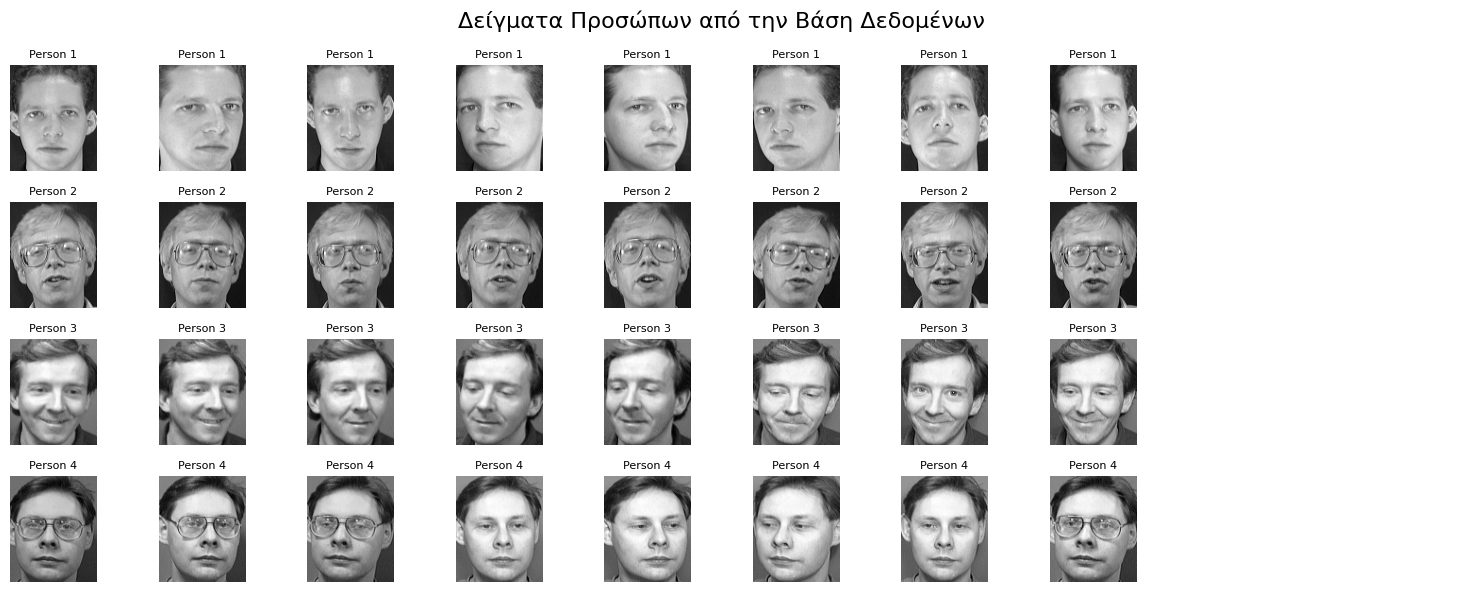


[INFO] Δημιουργία οπτικοποίησης μέσου προσώπου...


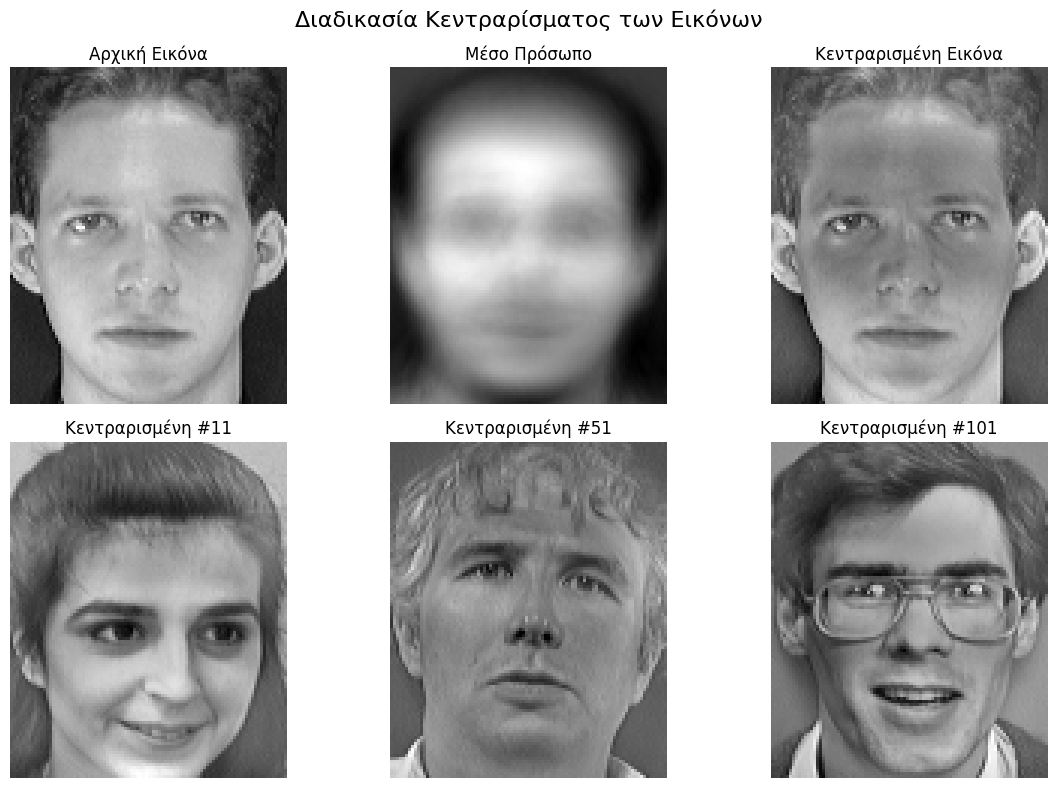


ΚΥΡΙΑ ΑΞΙΟΛΟΓΗΣΗ με k=32

[INFO] Εκτέλεση PCA-Eigenfaces με k=32...
[INFO] Υπολογίστηκαν 32 eigenfaces

[INFO] Υπολογισμός και οπτικοποίηση φάσματος eigenvalues...
[INFO] Χρειάζονται 97 eigenfaces για 90% της διακύμανσης
[INFO] Χρειάζονται 161 eigenfaces για 95% της διακύμανσης


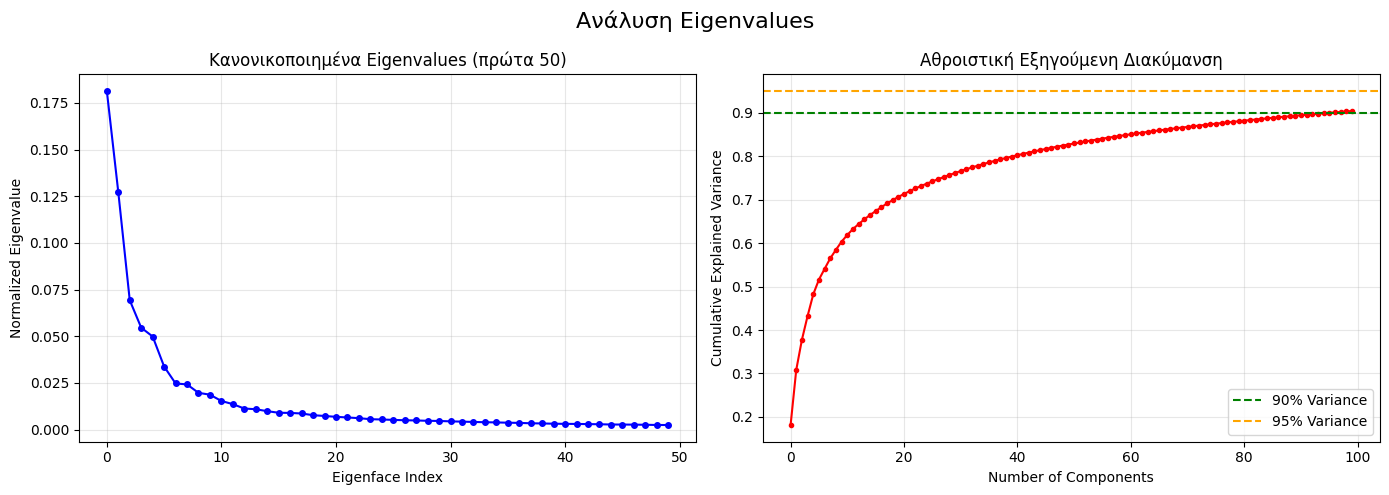


[INFO] Δημιουργία οπτικοποίησης 16 eigenfaces...


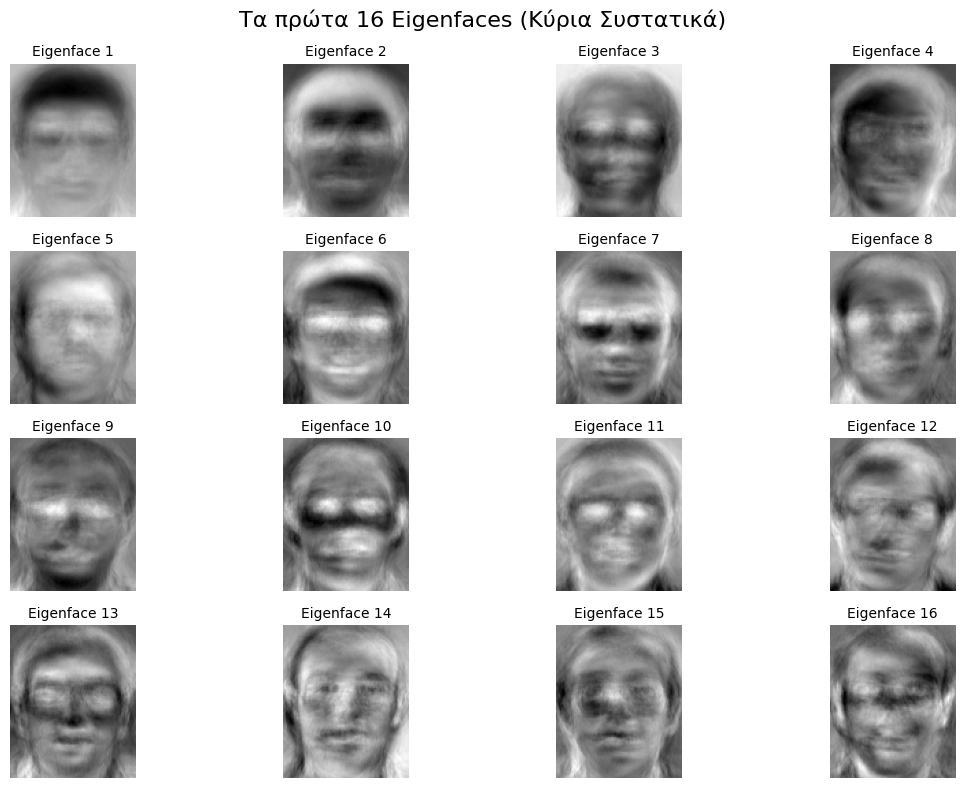


[INFO] Δημιουργία οπτικοποίησης ανακατασκευής προσώπου...


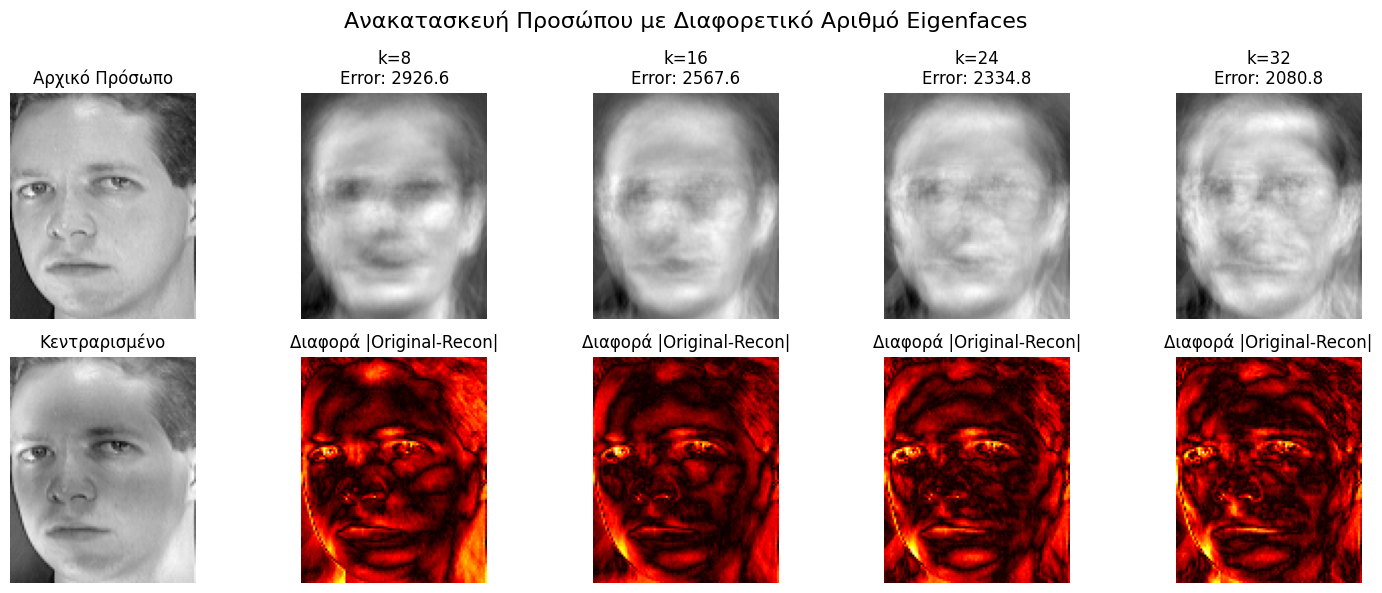


[INFO] Δημιουργία οπτικοποίησης χώρου eigenfaces...


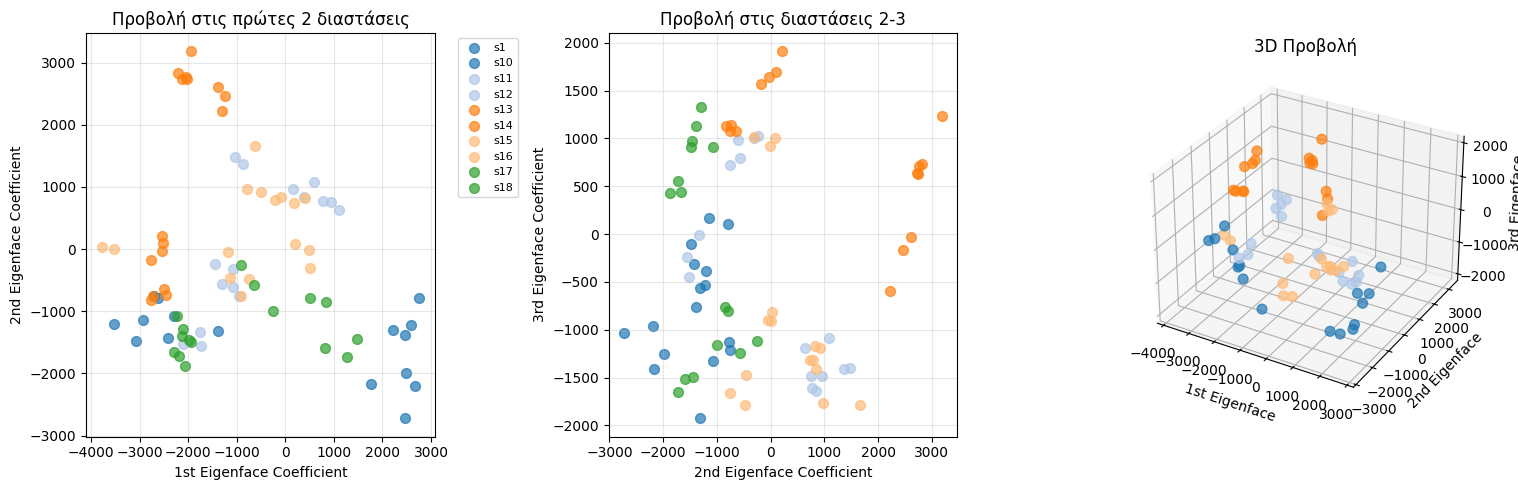

[INFO] Προβολή 80 test εικόνων στον χώρο eigenfaces
[INFO] Ολοκληρώθηκε η ταξινόμηση

[INFO] Δημιουργία παραδειγμάτων nearest neighbor...


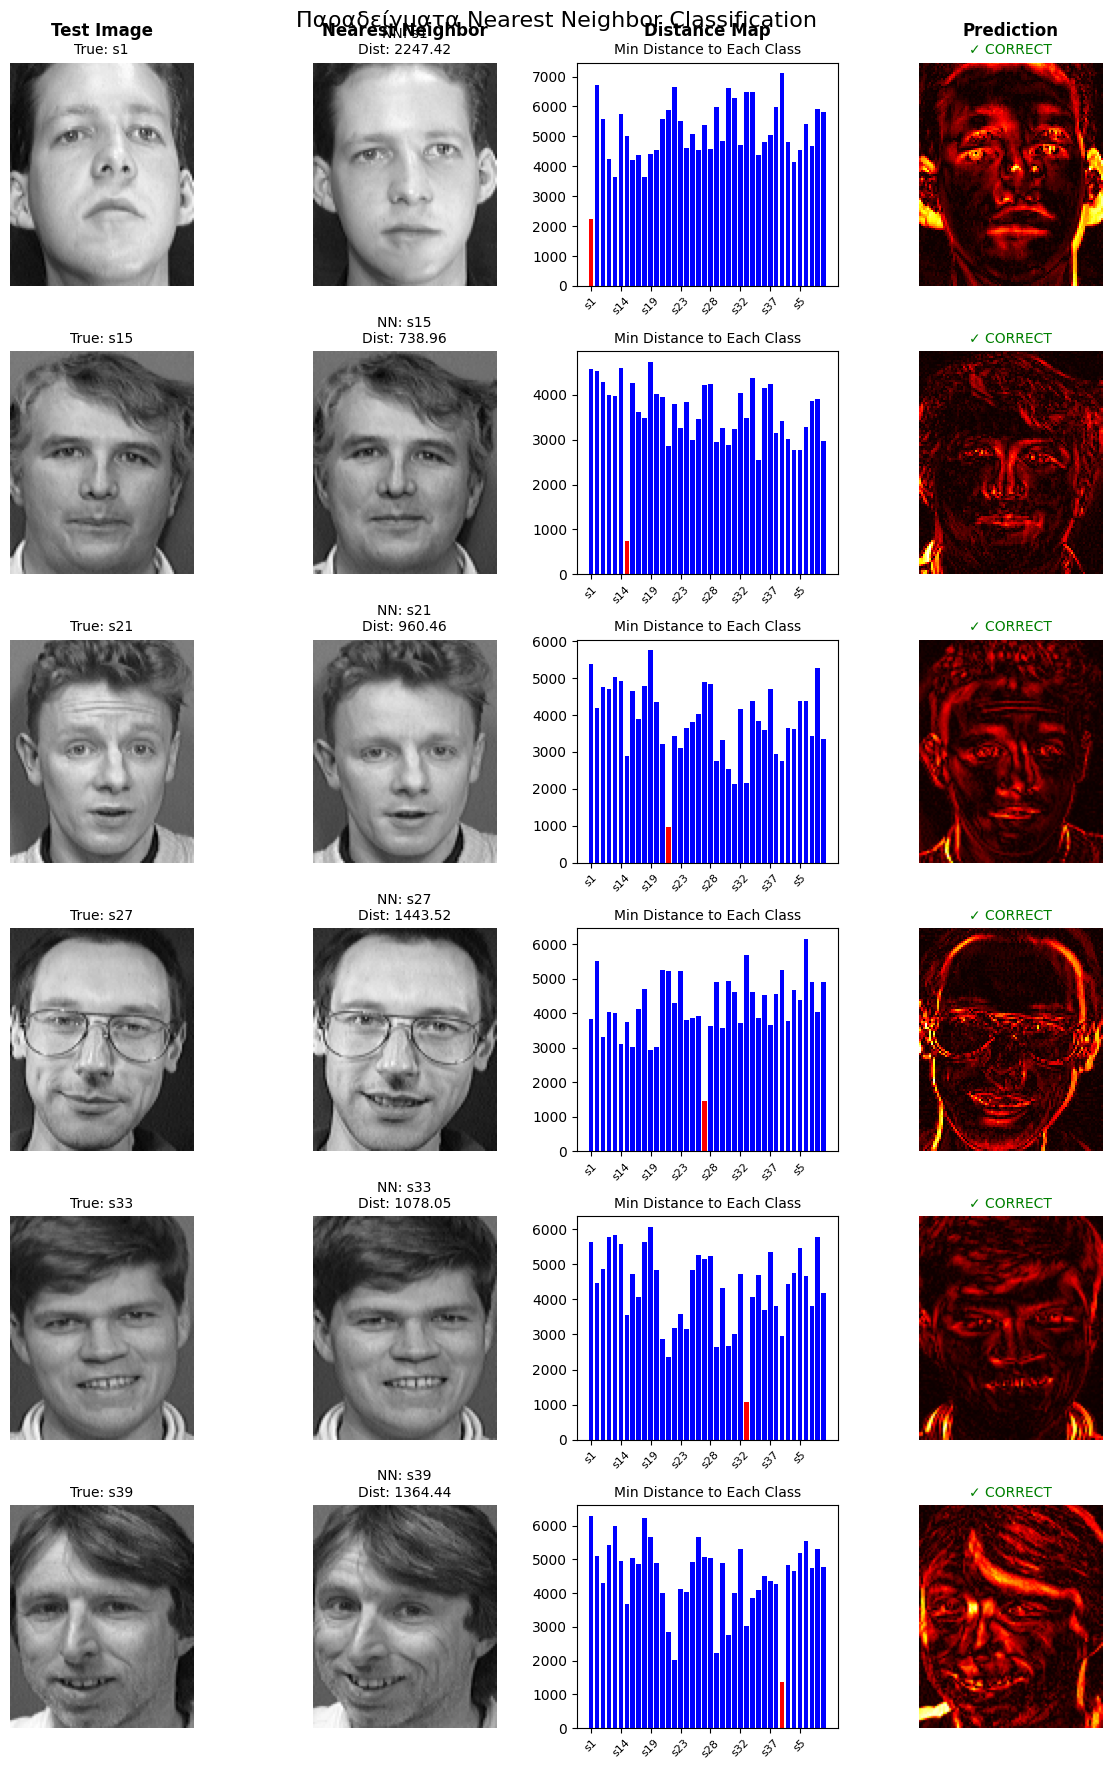


[INFO] Δημιουργία confusion matrix...


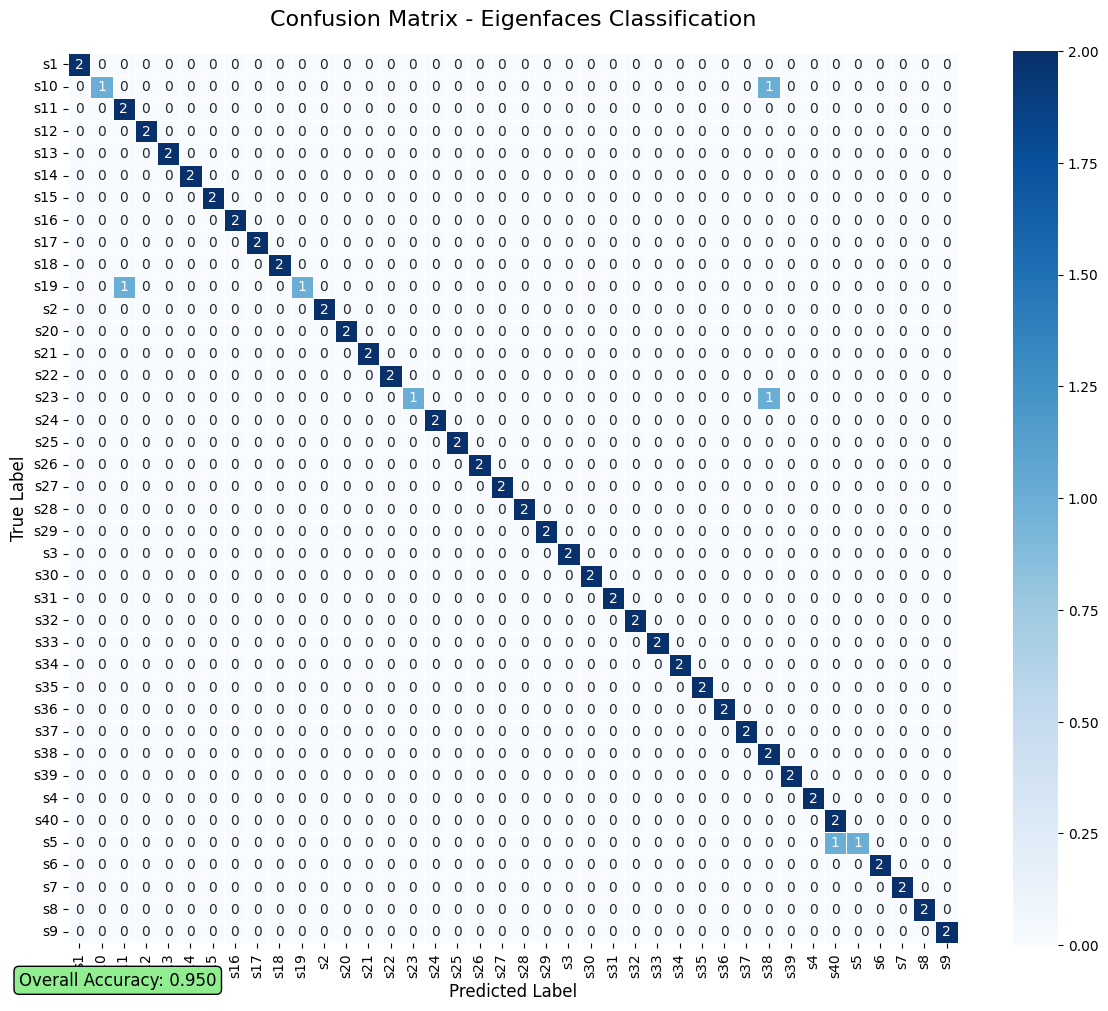


 ΤΕΛΙΚΑ ΑΠΟΤΕΛΕΣΜΑΤΑ
              precision    recall  f1-score   support

          s1      1.000     1.000     1.000         2
         s10      1.000     0.500     0.667         2
         s11      0.667     1.000     0.800         2
         s12      1.000     1.000     1.000         2
         s13      1.000     1.000     1.000         2
         s14      1.000     1.000     1.000         2
         s15      1.000     1.000     1.000         2
         s16      1.000     1.000     1.000         2
         s17      1.000     1.000     1.000         2
         s18      1.000     1.000     1.000         2
         s19      1.000     0.500     0.667         2
          s2      1.000     1.000     1.000         2
         s20      1.000     1.000     1.000         2
         s21      1.000     1.000     1.000         2
         s22      1.000     1.000     1.000         2
         s23      1.000     0.500     0.667         2
         s24      1.000     1.000     1.000         2
     

In [32]:
if __name__ == "__main__":
    main()